In [1]:
import numpy as np
import dense_nn
import sci_tools
import smc_samplers

import jax
import jax.numpy as jnp

import matplotlib.pylab as plt
%matplotlib inline

from time import time
from datetime import datetime

## Comparing SMC data annealers with minimization followed by MCMC

The first thing we need to do is to generate example data with which to train and test. Within this codebase, we can generate example regression problems in two main ways. One way is to generate a random polynomial using `gen_rand_poly` which is contained in `sci_tools`. The other way, which we will explore here, is use to draw a random model from a Bayesian neural net, and use another Bayesian net to infer the parameters of the first.


### Setting up the regression problem
The explanatory variables (the `INPUTS`) will be drawn from a Gaussian distribution. We'll make inputs 2D:

In [2]:
N = 200
ncolumns = 2
ndata = int(N / ncolumns)
INPUTS = np.random.normal(loc=0.0, scale=1, size=N).reshape(ndata, ncolumns)

Next, we'll set the number of layers in the neural nets. We'll make the hidden layer have 5 units and will make the output be 1D. For the activation function, we'll use a custom `tanh` function that has been shifted to always be positive. This shift removes the +/- symmetry of the output and makes the sampling easier. 

In [3]:
LAYERSHAPE = (ncolumns,5,1)
NONLINEAR = dense_nn.positanh

To generate the target, or response variable, we'll first generate a set of random weights by drawing each weight from a mean-centered Gaussian. The standard deviation of the Gaussians will be set as `PRIOR_STD`. Using these parameters, we'll next generate the target values as assign to `TRUE_TARGET`.

In [4]:
seed = 0 
PRIOR_STD = 0.5
params = dense_nn.init_nn_params(LAYERSHAPE, scale=PRIOR_STD, seed=seed)
TRUE_TARGET = dense_nn.nn_predict(params, INPUTS, nonlinearity=NONLINEAR)

We will try to estimate `TRUE_TARGET` after adding some white noise:

In [5]:
seed += 1
ERROR_STD = 0.15
key = jax.random.PRNGKey(seed + 1)
TARGET = TRUE_TARGET + jax.random.normal(key, shape=TRUE_TARGET.shape) * ERROR_STD

### Using MCMC to perform inference with Bayesian nets
Now that we have our explanatory and response variables, the task ahead of us is to see how well we can estimate the true response variables (`TRUE_TARGET`) from the noisy samples (`TARGET`).

We'll instantiate our Bayesian neural net using the same hyperparameters we used to generate the target values. Parameter inference will be performed using Langevin dynamics, so we'll also explictily set the integration parameters.

In [6]:
seed += 1
nn = dense_nn.GaussianDenseNN(INPUTS, TARGET, layer_shapes=LAYERSHAPE, prior_weight_scale=PRIOR_STD, seed=seed)
nn.reinit_integrator(dt=0.0001, gamma=100, mass=10)

To get a decent starting point for our MCMC sampling, we'll initialize weights with the maximum a posterior estimates. Under the hood, this is using adam to perform optimization.

In [7]:
nn.get_map(nsteps=5000)

0.0% completed. Energy = 204.41
10.0% completed. Energy = 114.44
20.0% completed. Energy = 0.23
30.0% completed. Energy = -52.91
40.0% completed. Energy = -53.68
50.0% completed. Energy = -54.02
60.0% completed. Energy = -54.22
70.0% completed. Energy = -54.25
80.0% completed. Energy = -54.25
90.0% completed. Energy = -54.26
100% completed. Energy = -54.26


Next, we'll do a quick burn-in/equilibration before the production. 

In [8]:
nn.seed += 1
key = jax.random.PRNGKey(seed)
split_keys = jax.random.split(key, 50000)
for i in range(50000):
    nn.step(key=split_keys[i])

Finally, we'll do a production sampling run. This is exactly the same as the burn-in, but this time we'll be recording certain variables for analysis afterwards

In [9]:
energy = []
trace_sigma = []
predictions = []

nsteps = 150000
save_freq = 100
percent = 10
completion_freq = int(nsteps * percent / 100)

nn.seed += 1
key = jax.random.PRNGKey(nn.seed)
split_keys = jax.random.split(key, nsteps)
nn.seed += 1

print('\nStarting MCMC')
k=0.
for i in range(nsteps):
    nn.step(key=split_keys[i])
    if i % save_freq == 0:
        energy.append(nn.energy(nn.unknowns))
        trace_sigma.append(nn.unknowns[0])
        predictions.append(nn.predict())
    if i % completion_freq == 0:
        print('{0}% completed.'.format(k*percent))
        k += 1
print('100% completed.')


Starting MCMC
0.0% completed.
10.0% completed.
20.0% completed.
30.0% completed.
40.0% completed.
50.0% completed.
60.0% completed.
70.0% completed.
80.0% completed.
90.0% completed.
100% completed.


#### Plotting
We can now assess the quality of the sampling and see how well we did in predicting the `TRUE_TARGET` values from the noisy `TARGET` values. Being a Bayesian excersise, we can also see how well the Gaussian noise on the `TRUE_TARGET` values.

Some quality assurance notes:
* What is called the "Energy" below is actually the negative log of the posterior. This should hopefully appear converged.
* The estimate of the white noise on the target is referred to as "Sigma" below. The credible intervals of Sigma should coincide with standard deviation we used for the white noise.
* The MCMC estimates of the noisless "true" response variables should be in good agreement.



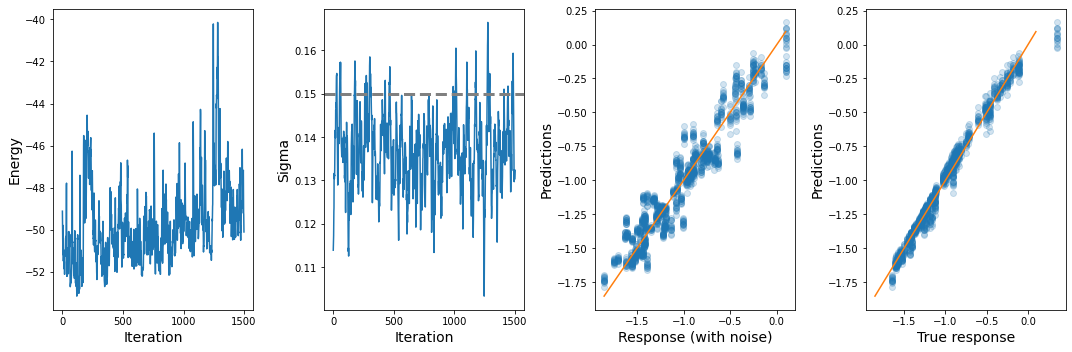

In [10]:
figure, ax = plt.subplots(1,4, figsize=(15,5))

arr_energy = np.hstack(energy)
ax[0].plot(arr_energy)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Energy', fontsize=14)

arr_trace_sigma = np.hstack(trace_sigma)
ax[1].plot(arr_trace_sigma)
ax[1].axhline(ERROR_STD, ls='--', label='True sigma', color='grey', lw=3)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].set_ylabel('Sigma', fontsize=14)

for i in range(1, len(predictions), 100):
    ax[2].scatter(nn.targets, predictions[i], alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[2].plot(x,x, color='C1')
ax[2].set_ylabel('Predictions', fontsize=14)
ax[2].set_xlabel('Response (with noise)', fontsize=14)

for i in range(1, len(predictions),100):
    ax[3].scatter(TRUE_TARGET, predictions[i], alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[3].plot(x,x, color='C1')
ax[3].set_ylabel('Predictions', fontsize=14)
ax[3].set_xlabel('True response', fontsize=14)

plt.tight_layout()
plt.savefig('bayesian_nn_mcmc_example.png', dpi=200)
plt.show()